In [2]:
import pandas as pd

In [3]:
llama_df = pd.read_csv('LLM_Run/good/llama70b.csv')
gemma_df = pd.read_csv('LLM_Run/good/gemma3_27b.csv')
qwen_df = pd.read_csv('LLM_Run/good/Qwen32b.csv')
input_df = pd.read_csv('sensitive/health_interview_proc_split.csv')

In [4]:
import ast
def convert_to_dict(x):
    try:
        # Try to safely evaluate the string as a Python dictionary
        output = ast.literal_eval(x)

        return output
    except (ValueError, SyntaxError) as e:
        # Print the exception for debugging
        print(f"Didn't work: {x}")
        print(f"AST Exception: {e}")
        return None

In [5]:
gemma_df.head(1)

,id,prompt,answer,json
0,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,[{'Original_Text': 'Impacts some of our poores...


In [6]:
def ExplodeJson(df):
    exploded_rows = []
    for index, row in df.iterrows():
        try:
            for json_object in convert_to_dict(row['json']):
                new_row = {
                    'id': row['id'],
                    'prompt': row['prompt'],
                    'answer': row['answer'],
                    'Original_Text': json_object.get('Original_Text', None),  # Handle missing keys
                    'Code': json_object.get('Code', None)
                }
                exploded_rows.append(new_row)
        except Exception as e:
            print(f"EXP: Exception: {row}, {e}")

    return pd.DataFrame(exploded_rows)

In [7]:
llama_exp = ExplodeJson(llama_df)
gemma_exp = ExplodeJson(gemma_df)
qwen_exp = ExplodeJson(qwen_df)

In [8]:
llama_exp.head()

,id,prompt,answer,Original_Text,Code
0,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,Impacts some of our poorest residents harder.,Disproportionate Impact
1,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,"Payson has a really active community, but ther...",Socio-Economic Disparities
2,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,The body’s defense mechanism to put on weight ...,Weight Gain as Coping Mechanism
3,1_PAY_F_Q10,Q10_Health Impact,Not many extracurricular activities outside of...,Not many extracurricular activities outside of...,Limited Community Resources
4,1_PAY_F_Q10,Q10_Health Impact,Not many extracurricular activities outside of...,Has a lot of fast-food restaurants and new one...,Unhealthy Food Environment


# Joins

In [9]:
joined_df = pd.merge(gemma_exp, llama_exp, how='outer', on=['id', 'prompt', 'answer', 'Original_Text'], suffixes=('_gemma', '_llama'))

In [10]:
joined_df = pd.merge(joined_df, qwen_exp, how='outer', on=['id', 'prompt', 'answer', 'Original_Text'], suffixes=('', '_qwen'))
joined_df.rename(columns={'Code': 'Code_qwen'}, inplace=True)

In [11]:
joined_df

,id,prompt,answer,Original_Text,Code_gemma,Code_llama,Code_qwen
0,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,Impacts some of our poorest residents harder.,Disproportionate Impact on Poverty,Disproportionate Impact,Health Disparity Among Poor
1,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,Payson has a really active community,Community Support,NaN,NaN
2,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,"Payson has a really active community, but ther...",NaN,Socio-Economic Disparities,Lack of Food Access and Trauma
3,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,The body’s defense mechanism to put on weight ...,Trauma-Induced Weight Gain,Weight Gain as Coping Mechanism,Weight Gain as Defense Mechanism
4,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,or are just traumatized (from childhood).,Childhood Trauma,NaN,NaN
...,...,...,...,...,...,...,...
6373,9_PRO_M_Q17,Q17_Other Thoughts,"You know, for example, for the parks, you know...","That's cool. It's good for people, for a lot o...",NaN,Perceived Benefits of Outdoor Exercise,Benefit of Exercise Facilities
6374,9_PRO_M_Q17,Q17_Other Thoughts,"You know, for example, for the parks, you know...","Yeah, yeah, yeah, like an outdoor gym for the ...",Adult-Focused Fitness Spaces,Outdoor Gym for Adults,Outdoor Gym for Adults
6375,9_PRO_M_Q17,Q17_Other Thoughts,"You know, for example, for the parks, you know...","You know, most of them is for kids.",Current Facilities Primarily for Children,Children-Oriented Facilities,Current Focus on Kids' Facilities
6376,9_PRO_M_Q17,Q17_Other Thoughts,"You know, for example, for the parks, you know...","for example, for the parks, you know, just for...",NaN,NaN,Suggestion for More Park Facilities


# Compressing DF

In [12]:
import pandas as pd
from sklearn.metrics import jaccard_score
from itertools import combinations
import numpy as np

def maxCommStr(s1, s2):
    """Finds the length of the longest common substring between two strings."""
    m, n = len(s1), len(s2)
    LCSuf = [[0] * (n + 1) for _ in range(m + 1)]
    res = 0

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if s1[i - 1] == s2[j - 1]:
                LCSuf[i][j] = LCSuf[i - 1][j - 1] + 1
                res = max(res, LCSuf[i][j])
            else:
                LCSuf[i][j] = 0
    return res

def substringOverlap(text1, text2, threshold=0.6):
    """Returns True if the longest common substring is at least 'threshold' percentage of the shorter text."""
    text1, text2 = text1.lower(), text2.lower()  # Normalize case
    lcs_length = maxCommStr(text1, text2)
    min_length = max(min(len(text1), len(text2)), 1)

    return (lcs_length / min_length) >= threshold

def mergeSimilarRows(df, threshold=0.9):
    tgt_cols = ["Code_llama", "Code_gemma", "Code_qwen"]

    full_rows = df.dropna(subset=tgt_cols, how="any")

    df = df[~df.index.isin(full_rows.index)].reset_index(drop=True)

    print(len(df))

    merged_rows = set()

    # Group by 'id' to only compare within the same id
    grouped = df.groupby("id")

    for _, group in grouped:
        indices = group.index.tolist()
        for i, j in combinations(indices, 2):
            if i in merged_rows or j in merged_rows:
                continue

            if substringOverlap(df.at[i, "Original_Text"], df.at[j, "Original_Text"], threshold):
                # Only merge if they do not overlap in non-null values
                can_merge = True
                for col in tgt_cols:
                    if pd.notna(df.at[i, col]) and pd.notna(df.at[j, col]):
                        can_merge = False  # Conflict: both rows have the same attribute

                if can_merge:
                    # Merge attributes only where one row has missing data
                    for col in tgt_cols:
                        if pd.isna(df.at[i, col]) and pd.notna(df.at[j, col]):
                            df.at[i, col] = df.at[j, col]  # Fill missing values
                    df.at[i, "Original_Text"] = max(df.at[i, "Original_Text"], df.at[j, "Original_Text"], key=len)
                    merged_rows.add(j)  # Mark row j for removal only if it contributes nothing unique

    # Drop merged rows and concatenate back the full rows
    df = df.drop(index=list(merged_rows)).reset_index(drop=True)
    return pd.concat([df, full_rows]).reset_index(drop=True)

merged_df = mergeSimilarRows(joined_df)

5603


# Examine Agreement

In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Load a sentence embedding model (SBERT)
model = SentenceTransformer('all-MiniLM-L6-v2')

def embed_text(text):
    return model.encode(text) if isinstance(text, str) else None

# Create an embedding dictionary
unique_codes = pd.unique(pd.concat([merged_df['Code_gemma'], merged_df['Code_llama'], merged_df['Code_qwen']]).values.ravel())
embedding_dict = {code: embed_text(code) for code in unique_codes if pd.notna(code)}

# Step 2: Compute cosine similarity for each coder pair
def compute_pairwise_similarity(code1, code2):
    if pd.isna(code1) or pd.isna(code2):
        return np.nan  # Missing codes should not be compared
    return cosine_similarity([embedding_dict[code1]], [embedding_dict[code2]])[0, 0]

# Apply similarity computation to each row
merged_df['AgreementGL'] = merged_df.apply(lambda row: compute_pairwise_similarity(row['Code_gemma'], row['Code_llama']), axis=1)
merged_df['AgreementGQ'] = merged_df.apply(lambda row: compute_pairwise_similarity(row['Code_gemma'], row['Code_qwen']), axis=1)
merged_df['AgreementLQ'] = merged_df.apply(lambda row: compute_pairwise_similarity(row['Code_llama'], row['Code_qwen']), axis=1)

/Users/ethan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ethan/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
merged_df

,id,prompt,answer,Original_Text,Code_gemma,Code_llama,Code_qwen,AgreementGL,AgreementGQ,AgreementLQ
0,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,"Payson has a really active community, but ther...",Community Support,Socio-Economic Disparities,Lack of Food Access and Trauma,0.194325,0.250070,0.345345
1,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,or are just traumatized (from childhood).,Childhood Trauma,NaN,NaN,NaN,NaN,NaN
2,0_PAY_M_Q10,Q10_Health Impact,Impacts some of our poorest residents harder. ...,there are those who are poor and do not have g...,Food Insecurity,NaN,NaN,NaN,NaN,NaN
3,0_PAY_M_Q14,Q14_Community Strengths,"Good friends, finances, outdoor community/comm...",outdoor community/community that supports outd...,Supportive Outdoor Community,Outdoor Recreation Opportunities,Outdoor Community Support,0.629212,0.912107,0.631007
4,0_PAY_M_Q15,Q15_Resources,Community resources at the hospital that have ...,Community resources at the hospital,Community Support Systems,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3757,9_PRO_M_Q16,Q16_Solutions,"I know I'm almost 40. After 40, if you have th...","After 40, if you have the body check, they giv...",Increased Screening After 40,Age-Based Health Screening,Increased Body Check Items Post-40,0.578534,0.557933,0.284113
3758,9_PRO_M_Q17,Q17_Other Thoughts,"You know, for example, for the parks, you know...","Because I would live in China, you know, for a...",Experience with Chinese Parks,Personal Experience Living Abroad,Long-term Residence in China,0.217403,0.329815,0.405616
3759,9_PRO_M_Q17,Q17_Other Thoughts,"You know, for example, for the parks, you know...","In China, in the community, in the park, there...",Chinese Parks Have Adult Gyms,Adult Fitness Facilities in China,Abundance of Adult Gyms in Chinese Parks,0.770833,0.941607,0.729254
3760,9_PRO_M_Q17,Q17_Other Thoughts,"You know, for example, for the parks, you know...","Yeah, yeah, yeah, like an outdoor gym for the ...",Adult-Focused Fitness Spaces,Outdoor Gym for Adults,Outdoor Gym for Adults,0.629353,0.629353,1.000000


In [16]:
len_q = len(merged_df[merged_df['Code_qwen'].notna()])
len_l = len(merged_df[merged_df['Code_llama'].notna()])
len_g = len(merged_df[merged_df['Code_gemma'].notna()])

len_g, len_q, len_l, sum([len_g, len_q, len_l])

(3339, 3002, 3012, 9353)

In [15]:
blah

NameError: name 'blah' is not defined

### Build Agreement Table

In [34]:
merged_df['MatchGL'] = merged_df['AgreementGL'] > .537
merged_df['MatchLQ'] = merged_df['AgreementLQ'] > .537
merged_df['MatchGQ'] = merged_df['AgreementGQ'] > .537

pct_agreement_LQ = sum(merged_df['MatchLQ']) / len(merged_df[merged_df['AgreementLQ'].notna()])
pct_agreement_GL = sum(merged_df['MatchGL']) / len(merged_df[merged_df['AgreementGL'].notna()])
pct_agreement_GQ = sum(merged_df['MatchGQ']) / len(merged_df[merged_df['AgreementGQ'].notna()])

total_agreement = (sum(merged_df['MatchLQ'])+ sum(merged_df['MatchGL']) + sum(merged_df['MatchGQ'])) / (len(merged_df[merged_df['AgreementLQ'].notna()]) + len(merged_df[merged_df['AgreementGL'].notna()]) + len(merged_df[merged_df['AgreementLQ'].notna()]))

pct_agreement_LQ, pct_agreement_GL, pct_agreement_GQ, total_agreement

(0.6205701078582434,
 0.6473625968277389,
 0.6558748635867588,
 0.6540554219916488)

In [39]:
len_q = len(merged_df[merged_df['Code_qwen'].notna()])
len_l = len(merged_df[merged_df['Code_llama'].notna()])
len_g = len(merged_df[merged_df['Code_gemma'].notna()])

holsti_agreement_LQ = 2*sum(merged_df['MatchLQ']) / (len_q + len_l)
holsti_agreement_GL = 2*sum(merged_df['MatchGL']) / (len_l + len_g)
holsti_agreement_GQ = 2*sum(merged_df['MatchGQ']) / (len_q + len_g)

holsti_agreement_LQ, holsti_agreement_GQ, holsti_agreement_GL

(0.5357499168606584, 0.5686800189244599, 0.5526688710439301)

In [17]:
blah

NameError: name 'blah' is not defined

### Krippendorffs Alpha (Depreciated)

In [16]:
import pandas as pd
import krippendorff

# Let's assume df has the similarity scores between each annotator pair:
# Columns: 'AgreementAB', 'AgreementBC', 'AgreementAC'

# Step 1: Construct rater-wise values for each item
# For each row, create three "ratings" from A, B, C to other annotators
ratings = []

for idx, row in merged_df.iterrows():
    if idx > 1000: # Limit size, else runtime breaks.
        break
    # These are symmetric agreements, so we store both directions
    ratings.append([idx, 'A', row['AgreementGL']])
    ratings.append([idx, 'B', row['AgreementGL']])

    ratings.append([idx, 'B', row['AgreementLQ']])
    ratings.append([idx, 'C', row['AgreementLQ']])

    ratings.append([idx, 'A', row['AgreementGQ']])
    ratings.append([idx, 'C', row['AgreementGQ']])

rating_df = pd.DataFrame(ratings, columns=['item', 'rater', 'score'])

# Step 2: Pivot into a matrix where rows = items, cols = raters
pivot = rating_df.pivot_table(index='rater', columns='item', values='score', aggfunc='mean')
matrix = pivot.values

print(pivot)

item       0         3         6         7         8         9         10    \
rater                                                                         
A      0.222198  0.770660  0.530866  0.297894  0.288720  0.849128  0.534263   
B      0.269835  0.630110  0.312165  0.531435  0.411227  0.743087  0.631944   
C      0.297708  0.771557  0.463370  0.440846  0.281982  0.804362  0.629702   

item       11        12        13    ...      986       987       989   \
rater                                ...                                 
A      0.757353  0.474770  0.428047  ...  0.850858  0.577260  0.922749   
B      0.878676  0.684167  0.527794  ...  0.834674  0.681256  0.943058   
C      0.878676  0.639001  0.609532  ...  0.872508  0.510640  0.960079   

item       990   992       996       997       998       999       1000  
rater                                                                    
A      0.830369   NaN  0.820774  0.807402  0.783678  0.438211  0.657449  
B      0.86

In [17]:
# Step 3: Compute Krippendorff's alpha for interval data
alpha = krippendorff.alpha(reliability_data=matrix, level_of_measurement='interval')

print(f"Krippendorff's alpha (interval): {alpha:.4f}")


Krippendorff's alpha (interval): 0.8661


In [18]:
cluster_df = pd.read_csv('cluster/cluster_scores.csv')

In [26]:
cluster_df.columns

Index(['n_neighbors', 'n_components', 'silhouette_score'], dtype='object')

In [31]:
cluster_df.reset_index(drop=True, inplace=True)

In [40]:
cluster_df['id'] = cluster_df.apply(lambda row: str((row['n_neighbors'], row['n_components'])), axis=1)

In [41]:
cluster_df

,n_neighbors,n_components,silhouette_score,id
0,5,10,0.602826,"(5.0, 10.0)"
1,5,15,0.622284,"(5.0, 15.0)"
2,5,20,0.604220,"(5.0, 20.0)"
3,5,25,0.601817,"(5.0, 25.0)"
4,5,50,0.614637,"(5.0, 50.0)"
5,5,100,0.605474,"(5.0, 100.0)"
6,10,10,0.591592,"(10.0, 10.0)"
7,10,15,0.611585,"(10.0, 15.0)"
8,10,20,0.569613,"(10.0, 20.0)"
9,10,25,0.593105,"(10.0, 25.0)"


/var/folders/fk/rsz_slmj7wj_dw8gjqj0qvsc0000gn/T/ipykernel_49862/2408194854.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x='id', y='silhouette_score', palette='viridis')


KeyError: 'silhouettescore'

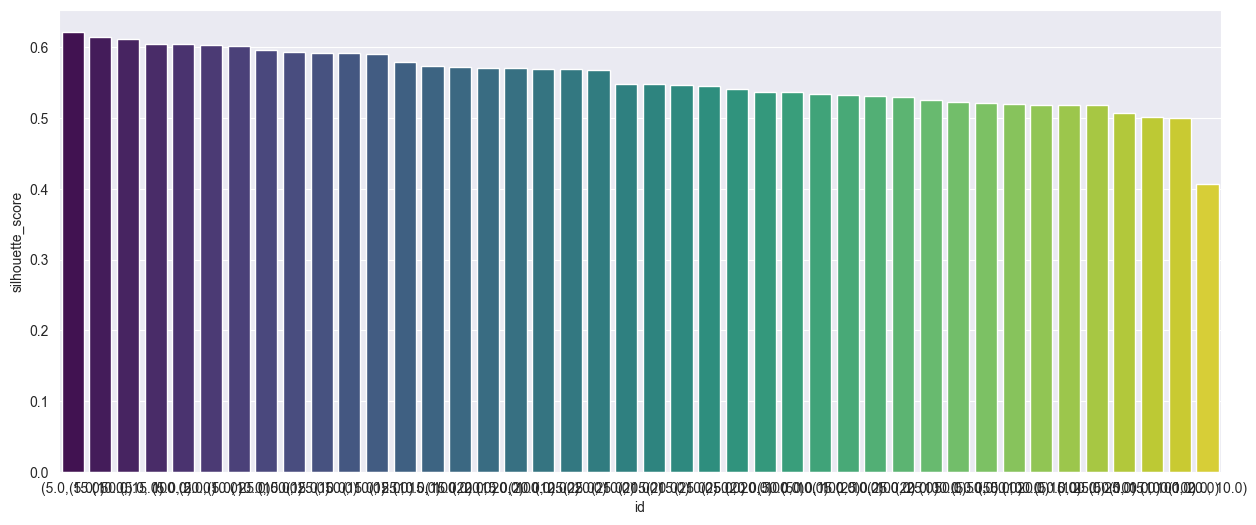

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure 'silhouette score' is sorted in descending order
df_sorted = cluster_df.sort_values(by='silhouette_score', ascending=False)

plt.figure(figsize=(15, 6))
sns.barplot(data=df_sorted, x='id', y='silhouette_score', palette='viridis')

# Label the top 10 bars
top10 = df_sorted.head(10)
for i, row in top10.iterrows():
    plt.text(
        x=df_sorted.index.get_loc(i),  # x = bar index in plot
        y=row['silhouettescore'] + 0.01,  # slightly above the bar
        s=f"{row['silhouette_score']:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        rotation=45
    )

plt.xticks(rotation=45)
plt.title("Silhouette Scores by ID")
plt.xlabel("ID")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()


/var/folders/fk/rsz_slmj7wj_dw8gjqj0qvsc0000gn/T/ipykernel_49862/67740270.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_sorted, x=df_sorted.index, y='silhouette_score', palette='viridis')


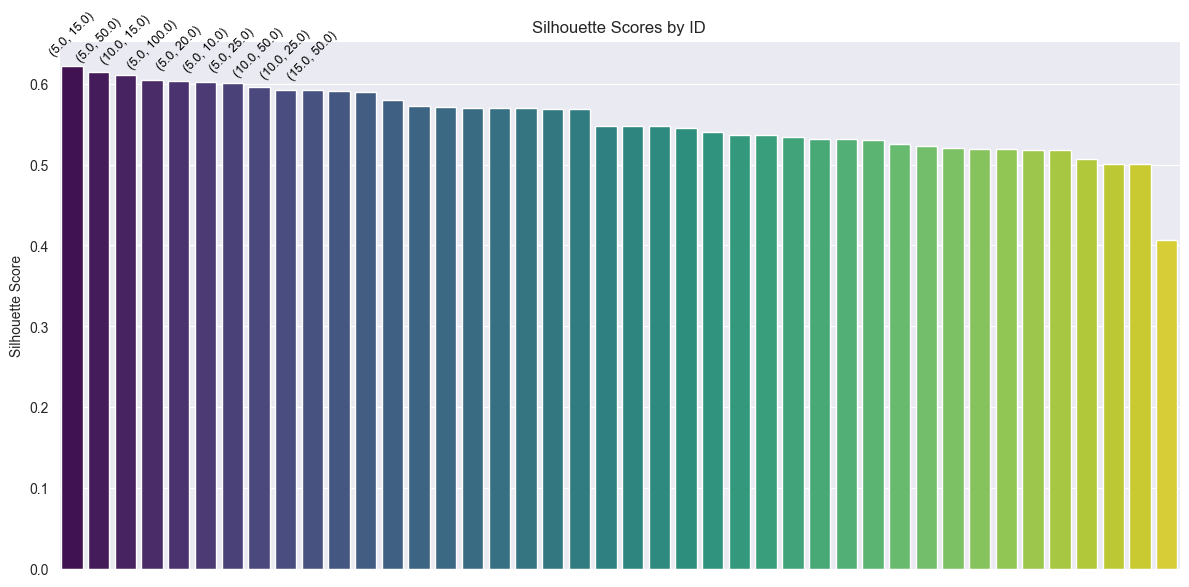

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort by silhouette score descending
df_sorted = cluster_df.sort_values(by='silhouette_score', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x=df_sorted.index, y='silhouette_score', palette='viridis')

# Label the top 10 bars with their 'id'
top10 = df_sorted.head(10)
for i, row in top10.iterrows():
    plt.text(
        x=i,
        y=row['silhouette_score'] + 0.01,
        s=str(row['id']),
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=45,
        color='black'
    )

plt.xticks([])  # Remove x-axis tick labels
plt.title("Silhouette Scores by ID")
plt.xlabel("")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()
